In [ ]:
import os 
import zipfile 

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torchvision
import torchvision.transforms as transforms

import glob
from PIL import Image

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from IPython.display import clear_output
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras import backend as K

from sklearn.utils import resample

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_dir = "images/"
metadata_path = "HAM10000_metadata.csv"

In [ ]:
#Lesion Dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
# Read metadata into dataframe
metadata = pd.read_csv(metadata_path)
skin_df = metadata

In [ ]:
# Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob.glob(os.path.join(data_dir, '*.jpg'))}

In [ ]:
#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
# Lesion code dictionary
lesion_code_dict = pd.Series(skin_df.dx.values,index=skin_df.cell_type_idx).to_dict()

lesion_code_dict

{2: 'bkl', 4: 'nv', 3: 'df', 5: 'mel', 6: 'vasc', 1: 'bcc', 0: 'akiec'}

In [ ]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,images\ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,images\ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,images\ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,images\ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,images\ISIC_0031633.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,images\ISIC_0033084.jpg,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,images\ISIC_0033550.jpg,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,images\ISIC_0033536.jpg,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,images\ISIC_0032854.jpg,Actinic keratoses,0


In [ ]:
# Attach images to the skin_df Dataframe
temp_arr, count = [], 0
for path in tqdm(skin_df['path']): 
    #print(path)
    temp_arr.append(np.asarray( Image.open(path).resize((100,75)) ))
    count += 1
  # print(f"Processed images: {count}")
  # if count % 10 == 0: clear_output()

skin_df['image'] = temp_arr


# skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

100%|███████████████████████████████████████████████████████████████████████████| 10015/10015 [01:14<00:00, 134.09it/s]


In [ ]:
# Separate the dataframe into Features and Targets data
features = skin_df.drop(columns=['cell_type_idx','dx'],axis=1)
target = skin_df['cell_type_idx']

In [ ]:
# Create First Train and Test sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20, random_state=1)

In [ ]:
# Create image arrays from the train and test sets
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

In [ ]:
# Class distribution before data augmentation
train_value_counts = y_train_o.value_counts()
print(train_value_counts)
print(f'Total images: {train_value_counts.sum()}')

4    5378
5     891
2     871
1     418
0     266
6     110
3      78
Name: cell_type_idx, dtype: int64
Total images: 8012


In [ ]:
# Data Augmentation
# Image data generator is used to generate the possible versions of data as given below.

dataaugment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10
    ) 

In [ ]:
# For each lesion code != 4, get the indices in y_train_o.
# For the same indices in x_train_o, augment the image present in the row.
reset_y_train_o = y_train_o.reset_index(drop=True)
reset_index = reset_y_train_o.index

print(len(y_train_o))

8012


In [ ]:
print(len(x_train))

8012


In [ ]:
# Class distribution after handling class imbalance
train_value_counts = y_train_o.value_counts()
print(train_value_counts)
print(f'Total images: {train_value_counts.sum()}')

4    5378
5     891
2     871
1     418
0     266
6     110
3      78
Name: cell_type_idx, dtype: int64
Total images: 8012


In [ ]:
# The normalisation is done using the training set Mean and Std. Deviation as reference
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [ ]:
# Splitting training into Train and Validatation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state=1)

# Reshaping the Images into 3 channels (RGB)
# height = 75, width = 100, canal = 3
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
# ResNet50
from keras.applications.resnet50 import ResNet50
input_shape = (75, 100, 3)
num_classes = 7

base_model = ResNet50(include_top=False, input_shape=(75,100, 3),pooling = 'avg', weights = 'imagenet');

model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))


for layer in base_model.layers:
    layer.trainable = True


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 23,850,887
Trainable params: 23,797,767
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# Define metrics 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# New baseline
# Define the optimizer
optimizer = Adam(learning_rate=0.001, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 # epsilon=None, 
                 decay=0.0, 
                 amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy", f1_m,precision_m, recall_m])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_validate = np.asarray(x_validate)
y_validate = np.asarray(y_validate)

In [ ]:
# Fit the model
epochs = 25
batch_size = 10
history = model.fit_generator(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                             epochs = epochs, validation_data = (x_validate,y_validate),
                             verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                             , callbacks=[learning_rate_reduction])

C:\Users\pshar\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:1945: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
721/721 [==============================] - 767s 1s/step - loss: 1.1363 - accuracy: 0.6583 - f1_m: 0.6096 - precision_m: 0.8147 - recall_m: 0.5003 - val_loss: 0.9343 - val_accuracy: 0.6808 - val_f1_m: 0.6774 - val_precision_m: 0.8389 - val_recall_m: 0.5721
Epoch 2/25
721/721 [==============================] - 687s 953ms/step - loss: 0.9996 - accuracy: 0.6688 - f1_m: 0.6402 - precision_m: 0.8200 - recall_m: 0.5358 - val_loss: 7.9443 - val_accuracy: 0.6808 - val_f1_m: 0.6986 - val_precision_m: 0.8081 - val_recall_m: 0.6202
Epoch 3/25
721/721 [==============================] - 710s 985ms/step - loss: 0.9743 - accuracy: 0.6721 - f1_m: 0.6545 - precision_m: 0.8150 - recall_m: 0.5559 - val_loss: 5.2495 - val_accuracy: 0.6796 - val_f1_m: 0.6251 - val_precision_m: 0.8812 - val_recall_m: 0.4868
Epoch 4/25
721/721 [==============================] - 616s 854ms/step - loss: 0.9747 - accuracy: 0.6738 - f1_m: 0.6462 - precision_m: 0.8096 - recall_m: 0.5465 - val_loss: 1.5079 - val_accuracy

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m', 'lr'])
Accuracy: 0.7472954392433167
loss: 0.689801812171936
f1_m: 0.7354151606559753
precision_m: 0.8354945182800293
recall_m: 0.6633846759796143


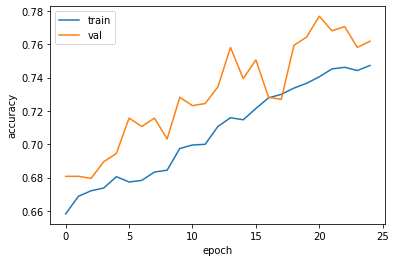

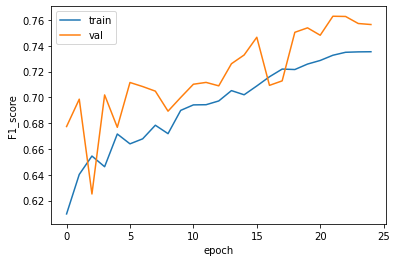

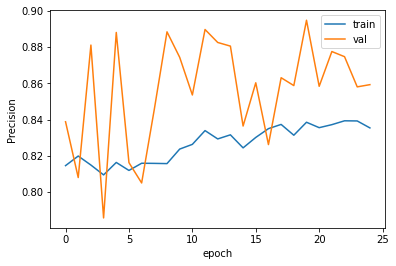

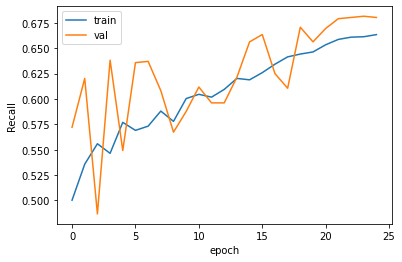

In [ ]:
# plot graphs from history
print(history.history.keys())
print(f'Accuracy: {history.history["accuracy"][-1]}')
print(f'loss: {history.history["loss"][-1]}')
print(f'f1_m: {history.history["f1_m"][-1]}')
print(f'precision_m: {history.history["precision_m"][-1]}')
print(f'recall_m: {history.history["recall_m"][-1]}')

plt.plot(history.history["accuracy"], label='accuracy')
plt.plot(history.history["val_accuracy"], label='Validaion accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["f1_m"], label='F1_score')
plt.plot(history.history["val_f1_m"], label='Validaion F1_score')
plt.ylabel('F1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["precision_m"], label='Precision')
plt.plot(history.history["val_precision_m"], label='Validaion Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["recall_m"], label='Recall')
plt.plot(history.history["val_recall_m"], label='Validaion Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# Evaluate model
test_eval = model.evaluate(x_test, y_test, verbose=1, return_dict=True)
validation_eval = model.evaluate(x_validate, y_validate, verbose=1, return_dict=True)
# model.save("model.h5")

26/26 [==============================] - 9s 335ms/step - loss: 0.6224 - accuracy: 0.7618 - f1_m: 0.7565 - precision_m: 0.8594 - recall_m: 0.6803


In [ ]:
for i, j in validation_eval.items():
    print(f'{i}: {j}')

loss: 0.6223573684692383
accuracy: 0.7618454098701477
f1_m: 0.7565236687660217
precision_m: 0.8593626022338867
recall_m: 0.6802884340286255


In [ ]:
for i, j in test_eval.items():
    print(f'{i}: {j}')

loss: 0.6498482823371887
accuracy: 0.7693459987640381
f1_m: 0.7572252750396729
precision_m: 0.8591374754905701
recall_m: 0.6795374155044556


In [ ]:
# Get predictions for plotting the confusion matrix
predictions = model.predict(x_test, verbose=1)

63/63 [==============================] - 23s 351ms/step


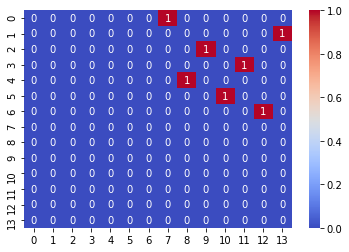

In [ ]:
# Plot the confusion matrix
predictions = np.argmax(predictions, axis=0)
y_test = np.argmax(y_test, axis=0)

sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap = 'coolwarm', fmt='.0f')
plt.show()